<a id = "1" ></a>
# Load Required Libraries

In [9]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns

from bs4 import BeautifulSoup
import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer 
from wordcloud import WordCloud, STOPWORDS
from nltk.tokenize import word_tokenize

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.feature_extraction.text import TfidfVectorizer

<a id = "2" ></a>
# Import the Dataset

T

In [11]:
#import dataset
df = pd.read_csv("d/spamham.csv")
#true = pd.read_csv("data/True.csv")

In [3]:
#data exploration
df.head(10)

,Category,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
5,spam,FreeMsg Hey there darling it's been 3 week's n...
6,ham,Even my brother is not like to speak with me. ...
7,ham,As per your request 'Melle Melle (Oru Minnamin...
8,spam,WINNER!! As a valued network customer you have...
9,spam,Had your mobile 11 months or more? U R entitle...


In [4]:
#true.head()

The columns in the datasets are:
* **title** - The title of the article
* **text** - The text of the article
* **subject** - The subject of the article
* **date** - The date at which the article was posted

The dataset contains no target variable. We need to create manually and add it to the datasets. We will create a binary variable called label. The label variable will have '0' for real news and '1' for fake news. 

In [5]:
from sklearn.preprocessing import LabelEncoder
le_3 = LabelEncoder()
label_3=le_3.fit_transform(df["Category"])
df["Category"]=label_3
df.head(10)


,Category,Message
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."
5,1,FreeMsg Hey there darling it's been 3 week's n...
6,0,Even my brother is not like to speak with me. ...
7,0,As per your request 'Melle Melle (Oru Minnamin...
8,1,WINNER!! As a valued network customer you have...
9,1,Had your mobile 11 months or more? U R entitle...


In [12]:
X_data=df[["Message"]]
Y_data=df["Category"]


In [13]:
#adding label columns to both fake news and true news dataset
#fake["label"] = 1
#true["label"] = 0

We will combine the seperate datasets into one for our further analysis

In [14]:
#combining both the datasets into one
#df = pd.concat([fake, true], ignore_index = True)
#df

<a id = "3" ></a>
# Exploratory Data Analysis

In [15]:
#EDA
#checking for missing values in the combined dataset
df.isnull().sum()

Category    0
Message     0
dtype: int64

In [16]:
d=df['Category'].unique()
d

array(['ham', 'spam'], dtype=object)

There are no null/missing values in the dataset.

Text(0.5, 1.0, 'Target variable count')

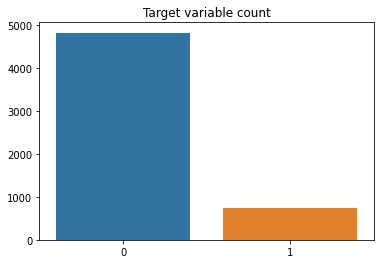

In [19]:
#checking for imbalance in the dataset
count = df['Category'].value_counts().values
sns.barplot(x = [0,1], y = count)
plt.title('Target variable count')

From the plot above, you can see there is no class imbalance in the target variable. We have almost equal instances for negative class ("0" - Real) and the class of interest ("1" - Fake).

In [20]:
#distribution of fake and real news among subjects
#plt.figure(figsize=(12,8))
#sns.countplot(x = "subject", data=df, hue = "label")
#plt.show()

<a id = "4" ></a>
# Data Cleaning
We will begin with the preprocessing steps before the text is fed into the model for prediction. 

In [22]:
#data cleaning content	source	author	time

#combining the title and text columns
#df['text'] = df['title'] + " " + df['text']
#deleting few columns from the data 
#del df['source']
#del df['author']
#del df['time']

<a id = "5" ></a>
## Removing stopwords
One of the major forms of pre-processing is to filter out useless data. In NLP, useless words, are referred to as stop words. We will use the `nltk` library for this purpose. This is how we are making our processed content more efficient by removing words that do not contribute to any future operations.

In [23]:
#choosing the language as english
stop = set(stopwords.words('english'))
#removing punctuation marks
punctuation = list(string.punctuation)
#adding punctuations to the list of stop words 
stop.update(punctuation)

#Removing the square brackets
def remove_brackets(text):
    return re.sub('\[[^]]*\]', '', text)

# Removing URL's
def remove_urls(text):
    return re.sub(r'http\S+', '', text)

#Removing the stopwords from text
def remove_stopwords(text):
    final_text = []
    text = text.lower()
    for i in text.split():
        if i.strip() not in stop:
            final_text.append(i.strip())
    return " ".join(final_text)

#Removing the noisy text
def clean_text(text):
    text = remove_brackets(text)
    text = remove_urls(text)
    text = remove_stopwords(text)
    return text

#Apply function on text column
df['Message']=df['Message'].apply(clean_text)
df['Message']

0       go jurong point, crazy.. available bugis n gre...
1                           ok lar... joking wif u oni...
2       free entry 2 wkly comp win fa cup final tkts 2...
3               u dun say early hor... u c already say...
4                 nah think goes usf, lives around though
                              ...                        
5567    2nd time tried 2 contact u. u £750 pound prize...
5568                         ü b going esplanade fr home?
5569               pity, mood that. so...any suggestions?
5570    guy bitching acted like i'd interested buying ...
5571                                      rofl. true name
Name: Message, Length: 5572, dtype: object

<a id = "6" ></a>
## Lemmatization
The next step is to perform Lemmatization. It is the process of converting a word to its base form. For example: 'Caring' -> 'Care'; 'hanging' -> 'hang'

In [24]:
#lemmatization
# Init the Wordnet Lemmatizer
lemmatizer = WordNetLemmatizer()

#A function which takes a sentence/corpus and gets its lemmatized version.
def lemmatize_text(text):
    token_words=word_tokenize(text) 
#we need to tokenize the sentence or else lemmatizing will return the entire sentence as is.
    lemma_sentence=[]
    for word in token_words:
        lemma_sentence.append(lemmatizer.lemmatize(word))
        lemma_sentence.append(" ")
    return "".join(lemma_sentence)

#Apply function on text column
df['Message']=df['Message'].apply(lemmatize_text)
df

,Category,Message
0,ham,"go jurong point , crazy .. available bugis n g..."
1,ham,ok lar ... joking wif u oni ...
2,spam,free entry 2 wkly comp win fa cup final tkts 2...
3,ham,u dun say early hor ... u c already say ...
4,ham,"nah think go usf , life around though"
...,...,...
5567,spam,2nd time tried 2 contact u. u £750 pound prize...
5568,ham,ü b going esplanade fr home ?
5569,ham,"pity , mood that . so ... any suggestion ?"
5570,ham,guy bitching acted like i 'd interested buying...


<a id = "7" ></a>
## Word Cloud
### Fake News Word Cloud


### Real News Word Cloud

#word cloud for real news
cloud = WordCloud(max_words = 500, stopwords = STOPWORDS, background_color = "white").generate(" ".join(df[df.Category == 0].Message))
plt.figure(figsize=(40, 30))
plt.imshow(cloud, interpolation="bilinear")
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

<a id = "8" ></a>
# N-gram Analysis

In [30]:
#finding n-grams
texts = ''.join(str(df['Message'].tolist()))

# first get individual words
tokenized = texts.split()

<a id = "9" ></a>
## Unigram Analysis

Text(0.5, 0, '# of Occurances')

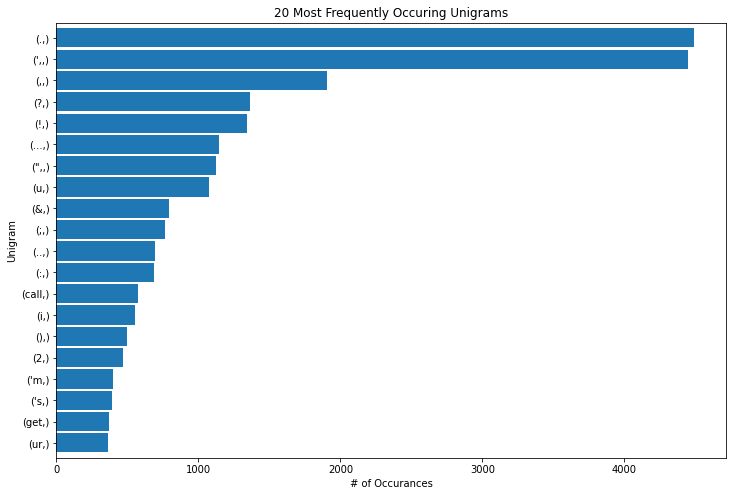

In [31]:
#unigram
unigram = (pd.Series(nltk.ngrams(tokenized, 1)).value_counts())[:20]
unigram.sort_values().plot.barh(width=.9, figsize=(12, 8))
plt.title('20 Most Frequently Occuring Unigrams')
plt.ylabel('Unigram')
plt.xlabel('# of Occurances')

<a id = "10" ></a>
## Bigram Analysis

Text(0.5, 0, '# of Occurances')

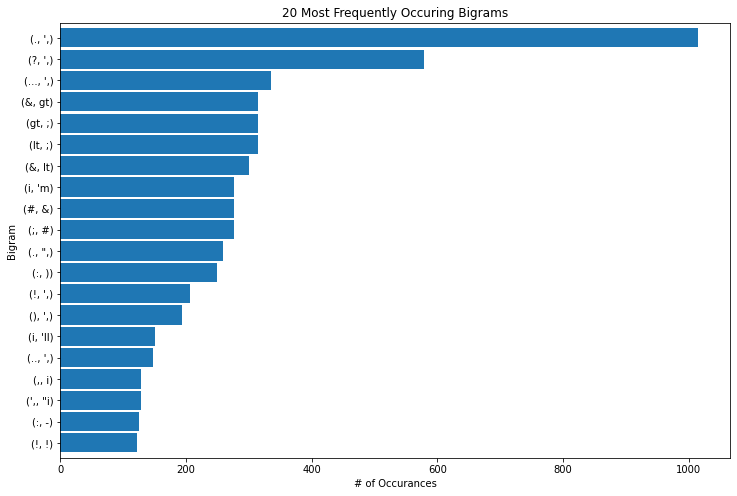

In [32]:
#bigrams
bigram = (pd.Series(nltk.ngrams(tokenized, 2)).value_counts())[:20]
bigram.sort_values().plot.barh(width=.9, figsize=(12, 8))
plt.title('20 Most Frequently Occuring Bigrams')
plt.ylabel('Bigram')
plt.xlabel('# of Occurances')

<a id = "11" ></a>
## Trigram Analysis

Text(0.5, 0, '# of Occurances')

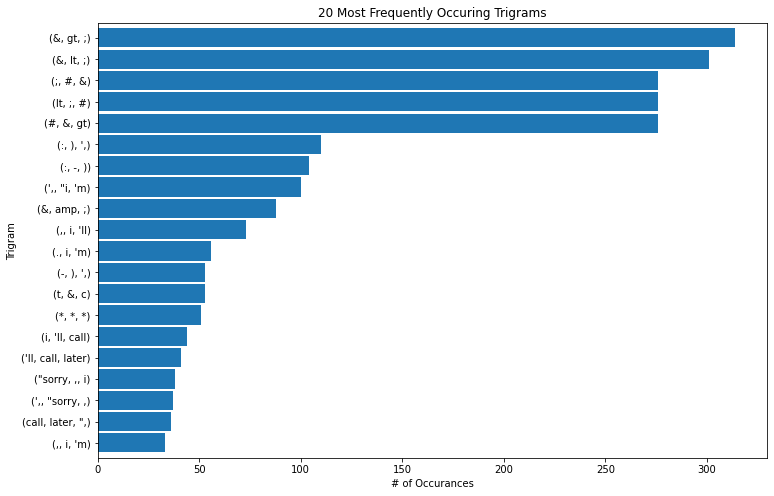

In [33]:
#trigrams
trigram = (pd.Series(nltk.ngrams(tokenized, 3)).value_counts())[:20]
trigram.sort_values().plot.barh(width=.9, figsize=(12, 8))
a=1.47
plt.title('20 Most Frequently Occuring Trigrams')
plt.ylabel('Trigram')
plt.xlabel('# of Occurances')

<a id = "12" ></a>
# Modeling
In this step, I am making use of various Classification models for prediction. The models use cleaned text data for analysis.

#### Using TF-IDF Vectorizer
This is an acronym than stands for "Term Frequency – Inverse Document Frequency" which are the components of the resulting scores assigned to each word.The TfidfVectorizer will tokenize documents, learn the vocabulary and inverse document frequency weightings, and allow you to encode new documents.

In [34]:
def get_prediction1(vectorizer, classifier, X_train, X_test, y_train, y_test):
    pipe = Pipeline([('vector', vectorizer),
                    ('model', classifier)])
    model = pipe.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print("Accuarcy: {}".format(round(accuracy_score(y_test, y_pred)*100*a,2)))
    cm = confusion_matrix(y_test, y_pred)
    print("Confusion Matrix: \n", cm)
    print(vectorizer.get_feature_names())


from sklearn.naive_bayes import MultinomialNB
X_train, X_test, y_train, y_test = train_test_split(df['content'], df['label'], test_size = 0.3, random_state= 0)

classifiers = [LogisticRegression(),KNeighborsClassifier(n_neighbors=5), DecisionTreeClassifier(), GradientBoostingClassifier(), 
               RandomForestClassifier(),MultinomialNB()]
for classifier in classifiers:
    print("\n\n", classifier)
    get_prediction1(TfidfVectorizer(), classifier, X_train, X_test, y_train, y_test)

In [37]:
#modeling
def get_prediction(vectorizer, classifier, X_train, X_test, y_train, y_test):
    pipe = Pipeline([('vector', vectorizer),
                    ('model', classifier)])
    model = pipe.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print("Accuarcy: {}".format(round(accuracy_score(y_test, y_pred)*100,2)))
    cm = confusion_matrix(y_test, y_pred)
    print("Confusion Matrix: \n", cm)
   
   


In [47]:
from sklearn.metrics import classification_report
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.metrics import confusion_matrix
#import SwarmPackagePy

In [54]:
from sklearn import svm
from sklearn.model_selection import GridSearchCV
from genetic_selection import GeneticSelectionCV
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

In [64]:
def geneticAlgorithm():
    global classifier
    text.delete('1.0', END)
    global ga_acc
    train = pd.read_csv(filename)
    test = pd.read_csv('heart_dataset/test.txt')
    test_X = test.values[:, 0:13] 
    X = train.values[:, 0:13] 
    y = train.values[:, 13]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1, random_state = 0)
    #estimator = svm.SVC(C=2.0,gamma='scale',kernel = 'rbf', random_state = 0)
    
    selector = GeneticSelectionCV(estimator,
                                  cv=5,
                                  verbose=1,
                                  scoring="accuracy",
                                  max_features=10,
                                  n_population=50,
                                  crossover_proba=0.5,
                                  mutation_proba=0.2,
                                  n_generations=200,
                                  crossover_independent_proba=0.5,
                                  mutation_independent_proba=0.05,
                                  tournament_size=3,
                                  n_gen_no_change=10,
                                  caching=True,
                                  n_jobs=-1)
    selector = selector.fit(X, y)
    y_pred = selector.predict(X_test)
    prediction_data = prediction(X_test, selector) 
    ga_acc = cal_accuracy(prediction_data, prediction_data,'GA Algorithm Accuracy, Classification Report & Confusion Matrix',2)
    classifier = selector
    cm = confusion_matrix(prediction_data, prediction_data)
    total=sum(sum(cm))
    selector = selector.fit(X_data,Y_data)

In [1]:
#selector = selector.fit(X_data,Y_data)
#y_pred = selector.predict(X_test)

In [38]:
#vectorizer=TfidfVectorizer() 
#print(vectorizer.get_feature_names())


X_train, X_test, y_train, y_test = train_test_split(df['Message'], df['Category'], test_size = 0.3, random_state= 0)

classifiers = [LogisticRegression(),KNeighborsClassifier(n_neighbors=5), DecisionTreeClassifier(), GradientBoostingClassifier(), 
               RandomForestClassifier(),MultinomialNB(),LinearSVC()]
for classifier in classifiers:
    print("\n\n", classifier)
    get_prediction(TfidfVectorizer(), classifier, X_train, X_test, y_train, y_test)
    
lr=[LogisticRegression()]


In [39]:
#pipeline implementation

X_train, X_test, y_train, y_test = train_test_split(df['Message'], df['Category'], test_size = 0.3, random_state= 0)

classifiers = [LogisticRegression(),KNeighborsClassifier(n_neighbors=5), DecisionTreeClassifier(), GradientBoostingClassifier(), 
               RandomForestClassifier(),MultinomialNB(),LinearSVC()]
for classifier in classifiers:
    print("\n\n", classifier)
    get_prediction(TfidfVectorizer(), classifier, X_train, X_test, y_train, y_test)
    
lr=[LogisticRegression()]





 LogisticRegression()
Accuarcy: 96.29
Confusion Matrix: 
 [[1447    4]
 [  58  163]]


 KNeighborsClassifier()
Accuarcy: 90.55
Confusion Matrix: 
 [[1451    0]
 [ 158   63]]


 DecisionTreeClassifier()
Accuarcy: 95.75
Confusion Matrix: 
 [[1425   26]
 [  45  176]]


 GradientBoostingClassifier()
Accuarcy: 96.95
Confusion Matrix: 
 [[1448    3]
 [  48  173]]


 RandomForestClassifier()
Accuarcy: 97.97
Confusion Matrix: 
 [[1449    2]
 [  32  189]]


 MultinomialNB()
Accuarcy: 97.01
Confusion Matrix: 
 [[1451    0]
 [  50  171]]


 LinearSVC()
Accuarcy: 98.86
Confusion Matrix: 
 [[1449    2]
 [  17  204]]


In [40]:
data=df.iloc[10:15,1]
data

10    i 'm gon na home soon want talk stuff anymore ...
11    six chance win cash ! 100 20,000 pound txt > c...
12    urgent ! 1 week free membership £100,000 prize...
13    i 've searching right word thank breather . pr...
14                                date sunday will ! ! 
Name: Message, dtype: object

<a id = "13" ></a>
# Conclusion
Decision Tree, Gradient Boosting and Random Forest Algorithms are giving an accuracy above 99% which is a really good score. There might be chances of overfitting which can be explored using validation curve. I will explore overfitting furthur. 

**Upvote if you like this notebook. Happy Learning!**